Veuillez importer les fichiers du projet via le lien ci-dessous :

https://drive.google.com/drive/folders/1WgmbgFeaDqc6EOHqdJPT4Fm3CN_ntv6v?usp=sharing

In [85]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Importation des modules nécessaires

In [86]:
from time import time
import numpy as np
import pandas as pd
import csv
import tensorflow as tf
import re, nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from gdrive.MyDrive.NLP_Sentiment_Analysis.randomTweets import *
from gdrive.MyDrive.NLP_Sentiment_Analysis.utils import *
import random

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from joblib import dump, load

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3

# Préparation de la dataset

In [ ]:
dataset = pd.read_csv('gdrive/MyDrive/NLP_Sentiment_Analysis/Dataset/training.1600000.processed.noemoticon.csv', 
                 encoding="ISO-8859-1",
                 usecols=[0, 5],             #to take only 2 useful column
                 names=["label","tweet"])

dataset['label'].replace([4, 0],[1, 0], inplace=True)

In [ ]:
dataset['label'].value_counts()
row_number = len(dataset['label']) + 1

## Affichage de la dataset

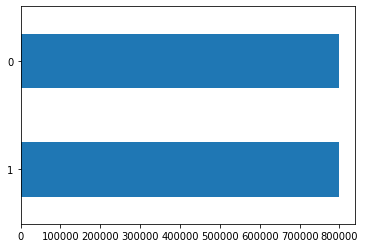

In [ ]:
dataset['label'].value_counts().plot(kind='barh')

## Observation d'un échantillon de la dataset

In [ ]:
random.seed(42)
dataset.iloc[random.sample(range(1, 1600000), 10), :]

,label,tweet
1340976,1,http://twitpic.com/6lt78 - Chris: Here's a pic...
233479,0,is d only 1 who didnt get pancakes 4 breakfast...
52452,0,@dr_zu DAMN It... I tried... not to be there.
1555145,1,@chynnaarielle Get 100 followers a day using w...
576779,0,I slept next to an open window and now i have ...
513576,0,OMG my test drive unlimited data has been corr...
468107,0,why are my parent's fighting? it's annoying. ...
292633,0,devasting news about the French Airliner. My p...
1544493,1,This year's Valeta sucked! I hope we'll do it ...
214948,0,PSP Go confirmed http://bit.ly/Px2ne Son....I...


On observe que les tweets peuvent contenir des mentions, des urls ou autres qui ne sont pas utiles à l'analyse de sentiment. Nous allons donc nettoyer les tweets.

## Nettoyage la dataset

Nous utiliserons la fonction clean trouvée sur Kaggle pour nettoyer les tweets.
Les contractions seront séparées, les charactères spéciaux seront supprimés, ainsi que les URLs, les mentions, les mots trops courts, et les stopwords. 

Les tweets seront aussi transformés en tokens grâce à la librairie ```nltk```.

In [ ]:
nltk.download('stopwords')

tokenizer = TweetTokenizer(strip_handles=True)
stop_words = set(stopwords.words('english'))
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset['tweet']

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: tweet, Length: 1600000, dtype: object

In [ ]:
i = 0
def increment():
    global i
    i += 1
def cleanerCall(s):
    increment()
    if i % 500 == 0:
      printProgressBar(i, row_number * 2)
    return clean(s, corpus, tokenizer, stop_words) # Function from kaggle in utils.py
def abbrevCall(s):
    increment()
    if i % 500 == 0:
      printProgressBar(i, row_number * 2)
    return convert_abbrev_in_text(s) # Function from kaggle in utils.py

dataset['tweet']=dataset['tweet'].apply(lambda s : cleanerCall(s))
dataset['tweet']=dataset['tweet'].apply(lambda s : abbrevCall(s))

del increment
del cleanerCall
del abbrevCall
del i

100.00% |███████████████████████████████████████████████████████████████████████████████████████████████████░|

In [ ]:
dataset = dataset.to_csv('gdrive/MyDrive/Colab_Notebooks/Dataset/cleaned_sentiment.csv', index=False)

# Dataset nettoyée

In [ ]:
# Read the cleaned dataset
dataset = pd.read_csv('gdrive/MyDrive/NLP_Sentiment_Analysis/Dataset/cleaned_sentiment.csv')

## Observation du même échantillon de la dataset

In [ ]:
random.seed(42)
dataset.iloc[random.sample(range(1, 1600000), 10), :]

,label,tweet
1340976,1,chris here pic might missing home
233479,0,didnt get pancakes breakfast coz woke like sup...
52452,0,damn it i tried
1555145,1,get followers day using wwwtweeterfollowcom on...
576779,0,i slept next open window really bad cold sore ...
513576,0,oh my god test drive unlimited data corrupted ...
468107,0,parents fighting annoying miss noise to be honest
292633,0,devasting news french airliner my prayers go f...
1544493,1,this years valeta sucked ! i hope better !
214948,0,psp go confirmed soni am dissapoint awful hard...


## Préparation de l'entraînement

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

Device: grpc://10.103.20.98:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.103.20.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.20.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


In [ ]:
# Create tuples (tweet, label)
corpus = list(zip(dataset['tweet'].values, dataset['label'].values))

embedding_dim = 100    # glove6b100
max_length = 20        # max lenght of a tweet
trunc_type='post'      # it will cut the tweet if it is longer than 20
padding_type='post'    # it will add zeros at the end the tweets if is smaller than 20
oov_tok = "<OOV>"      # for unseen words (out of vocabulary)
training_size=len(corpus)
test_portion=.025

In [ ]:
print(len(corpus))
corpus[:5]

1600000


[('awww bummer you shoulda got david carr third day d', 0),
 ('upset cannot update facebook texting might cry result school today also blah !',
  0),
 ('i dived many times ball managed save the rest go bounds', 0),
 ('whole body feels itchy like fire', 0),
 ('behaving i mad i cannot see', 0)]

## Répartition des données de test et d'entraînement

In [ ]:
sentences=[]
labels=[]

# Shuffle the dataset
random.shuffle(corpus)

# Separate labels and tweets
for x in range(training_size):
    sentences.append(str(corpus[x][0]))
    labels.append(corpus[x][1])

# Create vocabulary based on the tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Create the word index map
word_index = tokenizer.word_index
vocab_size=len(word_index)

# Create a one hot vector
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Create a training set
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [ ]:
print(vocab_size)
print(word_index['ok'])

# Save tokenizer for later
dump(tokenizer, 'gdrive/MyDrive/NLP_Sentiment_Analysis/RNNTokenizer.joblib')

417140
113


['gdrive/MyDrive/NLP_Sentiment_Analysis/RNNTokenizer.joblib']

## GLoVe : Création de la matrice de poids


In [ ]:
embeddings_index = {}

with open('gdrive/MyDrive/NLP_Sentiment_Analysis/Dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
print(embeddings_matrix.shape)
embeddings_index['love']

(417141, 100)


array([ 2.5975e-01,  5.5833e-01,  5.7986e-01, -2.1361e-01,  1.3084e-01,
        9.4385e-01, -4.2817e-01, -3.7420e-01, -9.4499e-02, -4.3344e-01,
       -2.0937e-01,  3.4702e-01,  8.2516e-02,  7.9735e-01,  1.6606e-01,
       -2.6878e-01,  5.8830e-01,  6.7397e-01, -4.9965e-01,  1.4764e+00,
        5.5261e-01,  2.5295e-02, -1.6068e-01, -1.3878e-01,  4.8686e-01,
        1.1420e+00,  5.6195e-02, -7.3306e-01,  8.6932e-01, -3.5892e-01,
       -5.1877e-01,  9.0402e-01,  4.9249e-01, -1.4915e-01,  4.8493e-02,
        2.6096e-01,  1.1352e-01,  4.1275e-01,  5.3803e-01, -4.4950e-01,
        8.5733e-02,  9.1184e-02,  5.0177e-03, -3.4645e-01, -1.1058e-01,
       -2.2235e-01, -6.5290e-01, -5.1838e-02,  5.3791e-01, -8.1040e-01,
       -1.8253e-01,  2.4194e-01,  5.4855e-01,  8.7731e-01,  2.2165e-01,
       -2.7124e+00,  4.9405e-01,  4.4703e-01,  5.5882e-01,  2.6076e-01,
        2.3760e-01,  1.0668e+00, -5.6971e-01, -6.4960e-01,  3.3511e-01,
        3.4609e-01,  1.1033e+00,  8.5261e-02,  2.4847e-02, -4.54

## Création du réseau neuronal LSTM

In [ ]:
with strategy.scope():    

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False), # Couche d'entrée chargée avec les poids de GLoVe
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(LSTM(units=128)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           41714100  
_________________________________________________________________
dropout (Dropout)            (None, 20, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 42,078,261
Trainable params: 364,161
Non-trainable params: 41,714,100
______________________________________

## Entraînement et sauvegarde du modèle

In [ ]:
num_epochs = 10

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

In [ ]:
history = model.fit(training_padded, 
                  training_labels, 
                  epochs=num_epochs, 
                  validation_data=(testing_padded, testing_labels),
                  batch_size = BATCH_SIZE,
                  verbose=1)

print("Training Complete")

Epoch 1/10
12188/12188 [==============================] - 248s 20ms/step - loss: 0.5255 - accuracy: 0.7361 - val_loss: 0.4776 - val_accuracy: 0.7689
Epoch 2/10
12188/12188 [==============================] - 242s 20ms/step - loss: 0.5019 - accuracy: 0.7526 - val_loss: 0.4728 - val_accuracy: 0.7720
Epoch 3/10
12188/12188 [==============================] - 241s 20ms/step - loss: 0.4925 - accuracy: 0.7593 - val_loss: 0.4620 - val_accuracy: 0.7796
Epoch 4/10
12188/12188 [==============================] - 243s 20ms/step - loss: 0.4863 - accuracy: 0.7632 - val_loss: 0.4571 - val_accuracy: 0.7839
Epoch 5/10
12188/12188 [==============================] - 244s 20ms/step - loss: 0.4818 - accuracy: 0.7664 - val_loss: 0.4530 - val_accuracy: 0.7853
Epoch 6/10
12188/12188 [==============================] - 244s 20ms/step - loss: 0.4783 - accuracy: 0.7686 - val_loss: 0.4537 - val_accuracy: 0.7866
Epoch 7/10
12188/12188 [==============================] - 245s 20ms/step - loss: 0.4750 - accuracy: 0.7704

In [ ]:
model.save('gdrive/MyDrive/NLP_Sentiment_Analysis/model.h5')

## Affichage de la progression du modèle

<Figure size 432x288 with 0 Axes>

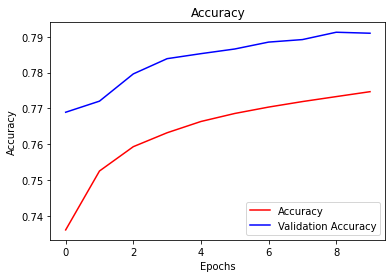

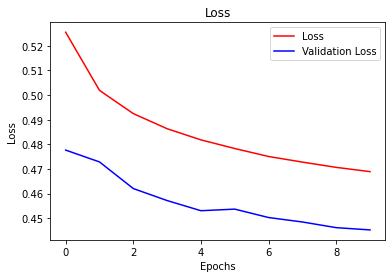

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

# Récupération de reviews et de tweets

In [87]:
def get_random_review():
  # Your Yelp API key here : 
  #@markdown Nécessite une clé d'API Yelp :
  api_key = "5uN5IS-gawRMFbmgNZCypm5Rh4NXxHn1VZ5fjhBBH0TnXbjxTadU9obeNL2A-LpLk-jxCQ2tNvIWBW-LS2Z7LR4SsVAPe_GRPNG--6arVVbTVzGfJMujdN0eWrE_YHYx" #@param {type:"string"}
  headers = {'Authorization': 'Bearer %s' % api_key}

  url = 'https://api.yelp.com/v3/businesses/search'
  params = {'term':'bookstore','location':'New York City'}

  req = requests.get(url, params=params, headers=headers)

  parsed = json.loads(req.text)
  
  businesses = parsed["businesses"]
  
  business = random.choice(businesses)

  id = business["id"]

  url="https://api.yelp.com/v3/businesses/" + id + "/reviews"

  req = requests.get(url, headers=headers)

  parsed = json.loads(req.text)

  reviews = parsed["reviews"]

  return random.choice(reviews)["text"]

In [88]:
print(get_random_review())

Great bookstore near BMCC campus. Of course you're not allowed to sit down or enjoy a cup of coffee like in the past. I used to kill time between classes as...


In [ ]:
#@markdown Nécessite une clé d'API Twitter : 
API_KEY = "" #@param {type:"string"}
SECRET = "" #@param {type:"string"}
# Your Twitter API credentials here : 
def get_random_tweet(target :string):
  credentials = {
          'consumer_key': str(API_KEY),
          'consumer_secret': str(SECRET)
      }
  return rt_get_random_tweet(target, credentials)['text']

In [ ]:
print(get_random_tweet("cat"))

# Pipeline complète

## Chargement du modèle

In [89]:
from tensorflow import keras
trained_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False), # Couche d'entrée chargée avec les poids de GLoVe
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(LSTM(units=128)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

trained_model.load_weights('gdrive/MyDrive/NLP_Sentiment_Analysis/model.h5')
rnn_tokenizer = load('gdrive/MyDrive/NLP_Sentiment_Analysis/RNNTokenizer.joblib')

In [116]:
max_length = 20        # Taille maximale d'un tweet
trunc_type='post'      # Tronque le tweet s'il est plus long que max_length
padding_type='post'

nltk.download('stopwords')

tokenizer = TweetTokenizer(strip_handles=True)
stop_words = set(stopwords.words('english'))
corpus = []

last = ""

def preprocess_string(tweet):
  tweet = clean(tweet, corpus, tokenizer, stop_words)
  tweet = convert_abbrev_in_text(tweet)
  return tweet

# Those thresholds are arbitrary
def interpret(value):
  if value < 0.1:
    return "Hateful"
  elif value < 0.25:
    return "Very Negative"
  elif value < 0.4:
    return "Negative"
  elif value < 0.6:
    return "Neutral"
  elif value < 0.75:
    return "Positive"
  elif value < 0.9:
    return "Very Positive"
  else:
    return "Delightful"

def rnn_lstm_pipeline_from_tweets(subject :str):
  raw_tweet = get_random_tweet(subject)
  print(raw_tweet)
  cleaned_tweet = preprocess_string(raw_tweet)
  #print("Processed Tweet : " + cleaned_tweet)
  word_vector = rnn_tokenizer.texts_to_sequences([cleaned_tweet])
  word_vector = pad_sequences([word_vector], maxlen=max_length, padding=padding_type, truncating=trunc_type)
  res = trained_model.predict(word_vector.reshape(1,-1))[0][0]
  return interpret(res), res

def rnn_lstm_pipeline_from_yelp():
  global last
  raw_review = get_random_review()
  last = raw_review
  print(raw_review)
  cleaned_review = preprocess_string(raw_review)
  #print("Processed Review : " + cleaned_review)
  word_vector = rnn_tokenizer.texts_to_sequences([cleaned_review])
  word_vector = pad_sequences(word_vector, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  res = trained_model.predict(word_vector.reshape(1,-1))[0][0]
  return interpret(res), res

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
for i in range(10):
  print(rnn_lstm_pipeline_from_yelp())

4 dollar signs on Yelp? Really? Found the prices to be very reasonable and the selection pretty solid, especially for its size.
('Positive', 0.6798574)
Man, this place is woke. I don't mean that sarcastically. Here, you'll find a ton of books written by people from historically marginalized backgrounds. And...
('Negative', 0.31043333)
Browsed their website, found a wonderful selection of books to take care of Christmas gifts for some special people. I ordered and was extremely pleased...
('Delightful', 0.97046757)
Really love Bluestockings! It's a fantastic store that has such a great selection of items including books, art, zines, tote bags, stickers, and more! Their...
('Delightful', 0.9740387)
I love this book store. It is the perfect little neighborhood gem. They have a terrific selection of books in all categories -- from children's books on up....
('Delightful', 0.96980846)
Last November, the Mystery Writers of America gave a prestigious lifetime achievement award to a novelist n

In [ ]:
for i in range(10):
  print(rnn_lstm_pipeline_from_tweets("bookstore"))

# Conclusion

Notre modèle obtient des résultats assez satisfaisants.

Nous pourrions entrainer notre modèle LSTM jusqu'à trouver un compromis entre les performances et l'overfitting. Nous pourrions également compléter l'étape de préprocessing en prenant en compte plus d'abbréviations par exemple.

Il serait également intéressant d'essayer différents GloVe pour trouver celui qui conviendrait le mieux à ce projet.
